<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/%5BE_04%5DMakeAlyricist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [E-04] 작사가 만들기 

![](https://d3s0tskafalll9.cloudfront.net/media/images/E-12-RNN2.max-800x600.png)

$n−1$개의 단어 시퀀스 $w_1, \cdots, w_{n-1}$
​
 가 주어졌을 때, $n$번째 단어 $w_n$ 
​
  으로 무엇이 올지를 예측하는 확률 모델을 언어 모델(Language Model) 이라고 부릅니다. 

In [ ]:
import os, re 
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

##1.데이터 준비하기

### 1.1구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 1.2 데이터 다운로드

In [ ]:
!mkdir -p lyricist/data/lyrics
!cp /content/gdrive/MyDrive/Data/lyrics.zip /content/lyricist/data/
!unzip -qq '/content/lyricist/data/lyrics.zip' -d /content/lyricist/data/lyrics

In [ ]:

txt_file_path = '/content/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Just before our love got lost you said', 'I am as constant as a northern star" and I said', 'Constantly in the darkness']


###1.3 데이터 전처리

####1.3.1 정제와 정규화

- 정제 : 갖고있는 코퍼스로부터 노이즈를 제거한다  
- 정규화 : 표현 방법이 다른 단어들을 통합시켜서 같은 단어로 만들어 준다.  


In [ ]:
def preprocess_sentence(sentence):
    #입력된 문장을
    # 1. [Chorus] 같은 문장을 지웁니다
    # 2. 소문자로 바꾸고, 양쪽 공백을 지웁니다
    # 3. 특수문자 양쪽에 공백을 넣고
    # 4. 여러개의 공백은 하나의 공백으로 바꿉니다
    # 5. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    # 6. 다시 양쪽 공백을 지웁니다
    # 7. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
    
    #sentence = re.sub(r'\[[^)]*\]',r'',sentence ) # 1
    sentence = sentence.lower().strip() # 2
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 3
    sentence = re.sub(r'[" "]+', " ", sentence) # 4
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 5
    sentence = sentence.strip() # 6
    if sentence : 
      sentence = '<start> ' + sentence + ' <end>' # 7
      return sentence


print(preprocess_sentence("[Chorus]HiHi my name is mk~!~!"))

<start> chorus hihi my name is mk ! ! <end>


In [ ]:
corpus = []
for sentence in raw_corpus:
    
    if len(sentence) == 0: continue
    
    # 정제를 해주세요 
    preprocessed_sentence = preprocess_sentence(sentence)

    # 정제를 하고 났을때 그냥 빈 (<start><end>) sentence 들은 빼주세요! 
    if not preprocessed_sentence : continue
    
    #preprocessing 하고 나서 15개 이상인 것들만 담아 줬어요
    if len(preprocessed_sentence.split(' ')) > 15 : continue
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> just before our love got lost you said <end>',
 '<start> i am as constant as a northern star and i said <end>',
 '<start> constantly in the darkness <end>',
 '<start> where s that at <end>',
 '<start> in the blue tv screen light <end>',
 '<start> i drew a map of canada <end>',
 '<start> oh canada <end>',
 '<start> you taste so bitter <end>',
 '<start> but you taste so sweet oh <end>',
 '<start> still be on my feet <end>']

####1.3.2 토큰화 및 패딩

In [ ]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words= 12000,                  #단어장 크기는 12,000 이상!
        filters=' ',
        oov_token="<unk>"
    )
    
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)  
    print(tensor) 
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[   2   32  173 ...    0    0    0]
 [   2    4  152 ...    3    0    0]
 [   2 3836   14 ...    0    0    0]
 ...
 [   2   42    6 ...    0    0    0]
 [   2   31    7 ...    0    0    0]
 [   2  301    1 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7efc5c9e8250>


In [ ]:
tensor[0]
tensor.shape

(156174, 15)

In [ ]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


####1.3.3 train data와 validation data 분리

In [ ]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2  32 173 149  36  37 319   7 117   3   0   0   0   0]
[ 32 173 149  36  37 319   7 117   3   0   0   0   0   0]


In [ ]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input,test_size=0.2, random_state=42)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)


# val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
# val_dataset = val_dataset.shuffle(BUFFER_SIZE)
# val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)



Source Train: (124939, 14)
Target Train: (124939, 14)


## 2.학습시키기

###2.2 모델 구성

val_loss < 2.2 라는 루브릭 기준을 위해,, 수많은 노력을 했습니다만,,, 젤 좋은건 그냥 기존의 모델에서 파라미터 조정,,,,

In [ ]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        #self.bidirectional_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size,  return_sequences=True))
        #self.bidirectional_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size//2,  return_sequences=True))
        #self.linear_1 = tf.keras.layers.Dense(64, activation='relu')
        
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        #self.dropout = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        #self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  #층을 추가해도 오히려 loss가 올라갔습니다 ㅜ
        #self.dropout = tf.keras.layers.Dropout(0.5)
        self.linear_2 = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        #out = self.bidirectional_1(out)
        #out = self.bidirectional_2(out)
        #out = self.linear_1(out)
        out = self.rnn_1(out)
        
        #out = self.rnn_3(out)
        #out = self.dropout(out)
        out = self.rnn_2(out)
        out = self.linear_2(out)
        
        #out = self.linear(out)
        
        return out
    
embedding_size = 2048
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

`self.bidirecttional` 모델을 추가하면 `val_loss`가 1epoch 에 바로 1점대로 가버렸는데, overfiting 된 것인지 작사를 시키면 단어하나만 뱉었습니다.. 또 dropout도 사용해봤는데 시간만 오래걸리고 성능은 오히려 더 안좋았습니다. 그래서 원래 기존의 모델 lstm에서 파라미터 값들만 바꾸어 학습시켜주었습니다.

In [ ]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
for src_sample, tgt_sample in train_dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 7001), dtype=float32, numpy=
array([[[-5.08949161e-04,  8.12172308e-04,  2.50336107e-05, ...,
         -6.07102062e-04, -3.93610710e-04,  2.74361635e-04],
        [-1.31007249e-03,  4.30693151e-04,  7.19370495e-04, ...,
         -1.11578137e-03, -6.23246771e-04,  5.45788265e-04],
        [-9.25141852e-04,  1.13526374e-04,  2.08646059e-03, ...,
         -1.59733614e-03, -6.94041009e-05,  4.24310827e-04],
        ...,
        [-4.57890594e-04,  1.86742388e-03, -1.56567723e-04, ...,
         -1.18137721e-03,  4.67115169e-05, -2.47342186e-03],
        [-1.50153250e-03,  1.02974387e-04, -2.39642613e-04, ...,
         -1.23546063e-03, -3.61442042e-04, -2.88662082e-03],
        [-1.40842434e-03, -1.24399038e-03, -4.47003345e-04, ...,
         -1.55160099e-03, -1.03294407e-03, -3.71202896e-03]],

       [[-5.08949161e-04,  8.12172308e-04,  2.50336107e-05, ...,
         -6.07102062e-04, -3.93610710e-04,  2.74361635e-04],
        [-7.48168444e-04,  1.13571656e-03,  4.

###2.2 모델 학습

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])
history = model.fit(enc_train, dec_train, epochs=7, batch_size=256, validation_data=(enc_val, dec_val), verbose=1)


Epoch 1/7
489/489 [==============================] - 330s 669ms/step - loss: 3.0151 - accuracy: 0.5194 - val_loss: 2.7064 - val_accuracy: 0.5436
Epoch 2/7
489/489 [==============================] - 326s 666ms/step - loss: 2.5315 - accuracy: 0.5578 - val_loss: 2.4666 - val_accuracy: 0.5686
Epoch 3/7
489/489 [==============================] - 326s 666ms/step - loss: 2.2135 - accuracy: 0.5914 - val_loss: 2.2986 - val_accuracy: 0.5932
Epoch 4/7
489/489 [==============================] - 326s 668ms/step - loss: 1.8971 - accuracy: 0.6339 - val_loss: 2.1762 - val_accuracy: 0.6163
Epoch 5/7
489/489 [==============================] - 326s 667ms/step - loss: 1.5975 - accuracy: 0.6834 - val_loss: 2.0917 - val_accuracy: 0.6384
Epoch 6/7
489/489 [==============================] - 326s 667ms/step - loss: 1.3471 - accuracy: 0.7310 - val_loss: 2.0476 - val_accuracy: 0.6563
Epoch 7/7
489/489 [==============================] - 326s 667ms/step - loss: 1.1634 - accuracy: 0.7701 - val_loss: 2.0430 - val_ac

data_set으로 묶어서 넣어주는 것보다 그냥 따로 넣어주는게 더 성능이 좋아서 따로 넣어 주었습니다.

##3.평가하기

In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i", max_len=20)

'<start> i m the one <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i wish", max_len=20)

'<start> i wish that you were here with me <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> who", max_len=20)

'<start> who s bad <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> my name", max_len=20)

'<start> my name is alexander hamilton <end> '

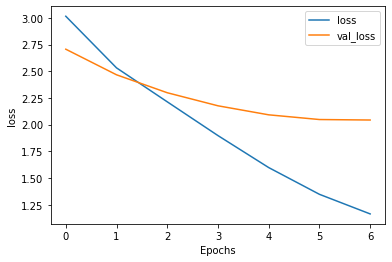

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
plot_graphs(history, 'loss')

--- 

## 🤔회고록🤔

- 루브릭... 2.2 누가 만든걸까요.. 2.2를위해서 힘을 너무 많이 뺐더닌 회고록에 쓸 힘이 남아있지않네요,,, 노드 제출후에 좀더 손을 봐야할 것 같습니다.
- val_loss가 2.7, 2.6인 모델이 2.2인모델 보다 훨씬 문장도 잘 만듭니다. val_loss가 낮다고 절대 좋은 모델이 아니라고 생각했으나 선웅님께서 일반적으로는 참인 명제이며 문제 정의를 어떻게 하냐,,가 중요하다고 하셨습니다. 
- 아직 모델에서 파라미터(ex. embedding size)들이 어떤역할을 하는지 몰라서 너무 랜덤적으로 값을 넣어서 해봤습니다. 
- 랜덤적으로 넣고 돌리는데 한번 학습시키는데 한시간은 넘게 걸리니,,, 실험하는 데에만 너무 많은 시간을 써버렸습니다.
- 딥러닝쪽은 항상 CV쪽만 했었는데 NLP를 해보니까 너무 어렵고 제길이 아니라는 것을 깨달았습니다. 


제가 시도한,, 많은,, 모델들중,, 모델의 summary,,, #은 valloss 값 입니다. 

In [ ]:
model.summary() #2.4160

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  10240512  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  6295552   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_2 (Dense)              multiple                  20501025  
Total params: 45,429,793
Trainable params: 45,429,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary() #2.5061

Model: "text_generator_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     multiple                  10240512  
_________________________________________________________________
lstm_18 (LSTM)               multiple                  6295552   
_________________________________________________________________
dropout_15 (Dropout)         multiple                  0         
_________________________________________________________________
dense_16 (Dense)             multiple                  20501025  
Total params: 37,037,089
Trainable params: 37,037,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()     #2.4497

Model: "text_generator_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     multiple                  10240512  
_________________________________________________________________
lstm_17 (LSTM)               multiple                  6295552   
_________________________________________________________________
dense_15 (Dense)             multiple                  20501025  
Total params: 37,037,089
Trainable params: 37,037,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()    #2.6248 

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  10240512  
_________________________________________________________________
lstm_2 (LSTM)                multiple                  6295552   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  20501025  
Total params: 45,429,793
Trainable params: 45,429,793
Non-trainable params: 0
______________________________________